In [1]:
import numpy as np
import matplotlib.pyplot as plt
import collections

In [2]:
def logml(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    
    Yt = Y.T # shape N x G
    A = sigmabeta2 * np.dot(Yt, Yt.T)
    A[np.diag_indices(nsamples)] += sigmax2
    logdetA = np.linalg.slogdet(A)
    invA = np.linalg.inv(A)
    partres = - 0.5 * nsamples * np.log(2 * np.pi) - 0.5 * logdetA[1]
    totres = 0
    for i in range(X.shape[0]):
        res = partres - 0.5 * np.dot(X[i, :].T, np.dot(invA, X[i, :]))
        totres += res
    return totres

In [3]:
def logml_alt(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    
    Yt = Y.T # shape N x G
    A = np.dot(Yt.T, Yt)
    A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    logdetA = np.linalg.slogdet(A)
    invA = np.linalg.inv(A)
    W = np.dot(Yt, np.dot(invA, Yt.T))
    
    partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA[1]
    totres = 0
    for i in range(X.shape[0]):
        #res = partres + 0.5 * np.linalg.multi_dot([X[i, :].T, Yt, invA, Yt.T, X[i, :]]) / sigmax2
        res = partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2
        totres += res
    return totres

In [4]:
def logml_alt_svd(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    
    
    Yt = Y.T # shape N x G
    A = np.dot(Yt.T, Yt)
    A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    logdetA = np.linalg.slogdet(A)
    U, S, Vt = np.linalg.svd(Yt)

    Smod = np.diag(np.square(S) / (np.square(S) + sigmax2 / sigmabeta2))
    W = np.dot(U, np.dot(Smod, U.T))
        
    partres = - 0.5 * ngenes * np.log(2 * np.pi * sigmabeta2) - 0.5 * logdetA[1]
    totres = 0
    for i in range(nsnps):
        res = partres + 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2
        totres += res
    return totres

In [5]:
def grad_logml(X, Y, sigmabeta, sigmax):
    nsnps = X.shape[0]
    nsamples = X.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    
    term1 = -ngenes

    #Smod = np.zeros((ngenes, ngenes))
    #Smod[np.arange(nsamples), np.arange(nsamples)] = np.square(S)
    #Smod[np.diag_indices_from(Smod)] += sigmax2 / sigmabeta2
    #B = np.linalg.multi_dot([Vt.T, Smod, Vt])
    #invB = np.linalg.inv(B)
    #term2 = sigmabeta2 * np.trace(invB * sigmax2 / sigmabeta2 / sigmabeta2)
    Smod = np.square(S) * sigmabeta2 / sigmax2
    term2 = (ngenes - nsamples) + np.sum(1 / (Smod + 1))
    
    #Smod = np.square(S) * sigmabeta2 / sigmax2
    #partsum = -ngenes + np.sum(1 / (Smod + 1))
    der = 0
    for i in range(nsnps):
        term3 = 0
        for k in range(nsamples):
            uk = U[:, k]
            sk = S[k]
            smod = sk * sk * sigmabeta2 / sigmax2
            term3 += smod * np.square(np.dot(uk, X[i,:])) / sigmax2 / np.square(smod + 1)
        der += term1 + term2 + term3
        #der += snpgrad
        #innersum = np.sum(np.square(np.dot(U.T, X[i,:])) * S2 / S2mod)
        #res = innersum + np.sum(np.square(np.dot(U.T, X[i,:])) * Smod / np.square(Smod + 1) / sigmax2)
        #der += res
    return der

In [7]:
### Simulation of data

ngenes = 1000
nsamples = 400
nsnps = 100
true_sigmabeta = 0.1
nmin = 2
nmax = int(ngenes)
ncausal = np.random.randint(nmin, nmax, nsnps)

Y = np.random.randn(ngenes * nsamples).reshape(ngenes, nsamples)

X = np.zeros((nsnps, nsamples))
for i in range(nsnps):
    choose = np.random.choice(ngenes, ncausal[i], replace=False)
    betas = np.random.normal(0, true_sigmabeta, ncausal[i])
    #betas = np.random.normal(0, true_sigmabeta, ngenes)
    #choose = np.arange(ngenes)
    X[i, :] = np.dot(Y[choose, :].T, betas) + np.random.normal(0, 1, nsamples)

In [8]:
### Check Q-score calculation using different methods

nsnps = X.shape[0]
nsamples = X.shape[1]
ngenes = Y.shape[0]
sigmabeta2 = 0.0001
sigmax2    = 1

Yt = Y.T # shape N x G
A = np.dot(Yt.T, Yt)
A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
logdetA = np.linalg.slogdet(A)
U, S, Vt = np.linalg.svd(Yt, full_matrices=False)

Qscore_wfull = [None for i in range(nsnps)]
Smod = np.diag(np.square(S) / (np.square(S) + sigmax2 / sigmabeta2))
W = np.dot(U, np.dot(Smod, U.T))
for i in range(nsnps):
    Qscore_wfull[i] = np.dot(X[i, :].T, np.dot(W, X[i,:]))
    
Qscore_wcalc = [None for i in range(nsnps)]
Wnew = 0
for i in range(nsamples):
    uk = U[:, i]
    sk2 = S[i] * S[i]
    Wnew += np.einsum('i,j', uk, uk) * sk2 / (sk2 + sigmax2 / sigmabeta2)
for i in range(nsnps):
    Qscore_wcalc[i] = np.dot(X[i, :].T, np.dot(W, X[i,:]))
    
Qscore_dcomp = [None for i in range(nsnps)]
S2 = np.square(S)
S2mod = S2 + sigmax2 / sigmabeta2
for i in range(nsnps):
    Qscore_dcomp[i] = np.sum(np.square(np.dot(U.T, X[i,:])) * S2 / S2mod)
    
    
print ("{:>15s} {:>15s} {:>15s}".format('W(numpy)', 'W(calculated)', 'Decomposed'))
print ("{:>15s} {:>15s} {:>15s}".format('========', '=============', '=========='))
for i in range(min(10, nsnps)):
    print ("{0:15.5f} {1:15.5f} {2:15.5f}".format(Qscore_wfull[i], Qscore_wcalc[i], Qscore_dcomp[i]))

       W(numpy)   W(calculated)      Decomposed
       ========   =============      ==========
      213.63499       213.63499       213.63499
      120.07692       120.07692       120.07692
      293.18754       293.18754       293.18754
      391.53170       391.53170       391.53170
      292.27669       292.27669       292.27669
      332.83084       332.83084       332.83084
      458.06217       458.06217       458.06217
       98.90022        98.90022        98.90022
      134.57325       134.57325       134.57325
      272.42739       272.42739       272.42739


In [9]:
### Marginal log likelihood (different ways of calculation)

sigmabeta = np.logspace(-3, 1, 50)
ysimp    = [logml        (X, Y, sbeta, 1) for sbeta in sigmabeta]
ycomp    = [logml_alt    (X, Y, sbeta, 1) for sbeta in sigmabeta]
ycompsvd = [logml_alt_svd(X, Y, sbeta, 1) for sbeta in sigmabeta]

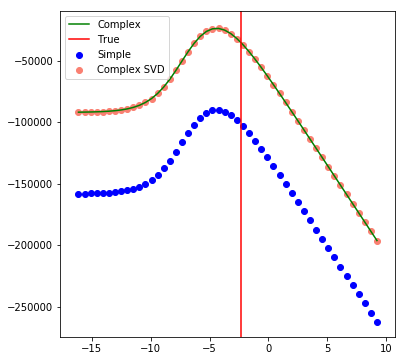

In [10]:
sigmabeta = np.logspace(-7, 4, 50)
true_alpha = np.log(true_sigmabeta)

fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

ax1.scatter(np.log(sigmabeta), ysimp,    color = 'blue', label = 'Simple')
ax1.plot(np.log(sigmabeta), ycomp,    color = 'green', label = 'Complex')
ax1.scatter(np.log(sigmabeta), ycompsvd, color = 'salmon', label = 'Complex SVD')

ax1.axvline(x = true_alpha, color = 'red', label = 'True')

plt.legend(loc = 'upper left')
plt.show()

In [11]:
def numerical_gradient(X, Y, sbeta, sigmax, method='logml'):
    logsbeta = np.log(sbeta)
    delta = 0.001 * logsbeta
    sbeta_shifted = np.exp(logsbeta + delta)
    if method == 'logml':
        y    = logml(X, Y, sbeta, sigmax)
        ynew = logml(X, Y, sbeta_shifted, sigmax)
    elif method == 'logml_alt':
        y    = logml_alt(X, Y, sbeta, sigmax)
        ynew = logml_alt(X, Y, sbeta_shifted, sigmax)
    elif method == 'logml_alt_svd':
        y    = logml_alt_svd(X, Y, sbeta, sigmax)
        ynew = logml_alt_svd(X, Y, sbeta_shifted, sigmax)
    grad = (ynew - y) / delta
    return grad

grad         = [numerical_gradient(X, Y, sbeta, 1, 'logml')         for sbeta in sigmabeta]
grad_alt     = [numerical_gradient(X, Y, sbeta, 1, 'logml_alt')     for sbeta in sigmabeta]
grad_alt_svd = [numerical_gradient(X, Y, sbeta, 1, 'logml_alt_svd') for sbeta in sigmabeta]

In [12]:
grad_theory  = [grad_logml(X, Y, sbeta, 1) for sbeta in sigmabeta]

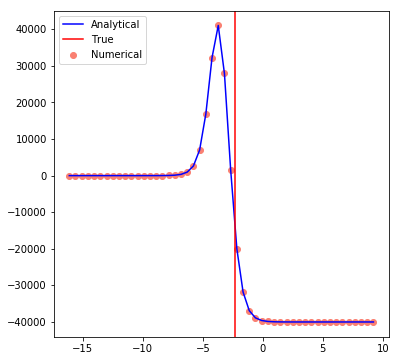

In [13]:
fig = plt.figure(figsize = (6, 6))
ax1 = fig.add_subplot(111)

#ax1.scatter(np.log(sigmabeta), grad,         color = 'blue', label = 'Simple')
#ax1.plot   (np.log(sigmabeta), grad_alt,     color = 'green', label = 'Complex')
ax1.scatter(np.log(sigmabeta), grad_alt_svd, color = 'salmon', label = 'Numerical')
ax1.plot   (np.log(sigmabeta), grad_theory,  color = 'blue', label = 'Analytical')

ax1.axvline(x = true_alpha, color = 'red', label = 'True')

plt.legend(loc = 'upper left')
#ax1.set_ylim(-100000, 100000)
plt.show()

In [14]:
# First term

def term1(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    return -0.5 * ngenes * np.log(2 * np.pi * sigmabeta2)

def term2(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax    
    Yt = Y.T # shape N x G
    A = np.dot(Yt.T, Yt)
    A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    logdetA = np.linalg.slogdet(A)
    return -0.5 * logdetA[1]

def term3(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax    
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    Smod = np.diag(np.square(S) / (np.square(S) + sigmax2 / sigmabeta2))
    W = np.dot(U, np.dot(Smod, U.T))
    i = 0
    res = 0.5 * np.dot(X[i, :].T, np.dot(W, X[i,:])) / sigmax2
    return res

def grad_term1(X, Y, sigmabeta, sigmax):
    ngenes = Y.shape[0]
    return -ngenes

def grad_term2(X, Y, sigmabeta, sigmax):
    nsamples = Y.shape[1]
    ngenes = Y.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    Yt = Y.T
    #A = np.dot(Yt.T, Yt)
    #A[np.diag_indices(ngenes)] += sigmax2 / sigmabeta2
    #invA = np.linalg.inv(A)
    #der = sigmabeta2 * np.trace(invA * sigmax2 / sigmabeta2 / sigmabeta2)
    U, S, Vt = np.linalg.svd(Yt)
    Smod = np.zeros((ngenes, ngenes))
    Smod[np.arange(nsamples), np.arange(nsamples)] = np.square(S)
    Smod[np.diag_indices_from(Smod)] += sigmax2 / sigmabeta2
    B = np.linalg.multi_dot([Vt.T, Smod, Vt])
    invB = np.linalg.inv(B)
    der = sigmabeta2 * np.trace(invB * sigmax2 / sigmabeta2 / sigmabeta2) 
    #nsamples = X.shape[1]
    #sigmabeta2 = sigmabeta * sigmabeta
    #sigmax2    = sigmax    * sigmax
    #Yt = Y.T # shape N x G
    #U, S, Vt = np.linalg.svd(Yt)
    #der = 0
    #for k in range(U.shape[0]):
    #    sk = S[k]
    #    smod = sk * sk * sigmabeta2 / sigmax2
    #    der += 1 / (smod + 1)
    return der

def grad_term3(X, Y, sigmabeta, sigmax):
    nsamples = X.shape[1]
    nsnps = X.shape[0]
    sigmabeta2 = sigmabeta * sigmabeta
    sigmax2    = sigmax    * sigmax
    Yt = Y.T # shape N x G
    U, S, Vt = np.linalg.svd(Yt)
    der = 0
    for k in range(nsamples):
        sk = S[k]
        uk = U[:, k]
        snppart = np.square(np.dot(uk, X[0,:]))
        smod = sk * sk * sigmabeta2 / sigmax2
        der += smod * snppart / sigmax2 / np.square(smod + 1)
    return der

def grad_numeric(X, Y, sigmabeta, sigmax, method = 'term1'):
    logsbeta = np.log(sigmabeta)
    delta = 0.00001 * logsbeta
    sigmabeta_shifted = np.exp(logsbeta + delta)
    if method == 'term1':
        y    = term1(X, Y, sigmabeta, sigmax)
        ynew = term1(X, Y, sigmabeta_shifted, sigmax)
    elif method == 'term2':
        y    = term2(X, Y, sigmabeta, sigmax)
        ynew = term2(X, Y, sigmabeta_shifted, sigmax)
    elif method == 'term3':
        y    = term3(X, Y, sigmabeta, sigmax)
        ynew = term3(X, Y, sigmabeta_shifted, sigmax)
    grad = (ynew - y) / delta
    return grad

In [15]:
y1 = [term1(X, Y, sbeta, 1) for sbeta in sigmabeta]
y1_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term1') for sbeta in sigmabeta]
y1_gradtheory  = [grad_term1(X, Y, sbeta, 1) for sbeta in sigmabeta]

In [16]:
y2 = [term2(X, Y, sbeta, 1) for sbeta in sigmabeta]
y2_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term2') for sbeta in sigmabeta]
y2_gradtheory  = [grad_term2(X, Y, sbeta, 1) for sbeta in sigmabeta]

In [17]:
y3 = [term3(X, Y, sbeta, 1) for sbeta in sigmabeta]
y3_gradnumeric = [grad_numeric(X, Y, sbeta, 1, 'term3') for sbeta in sigmabeta]
y3_gradtheory  = [grad_term3(X, Y, sbeta, 1) for sbeta in sigmabeta]

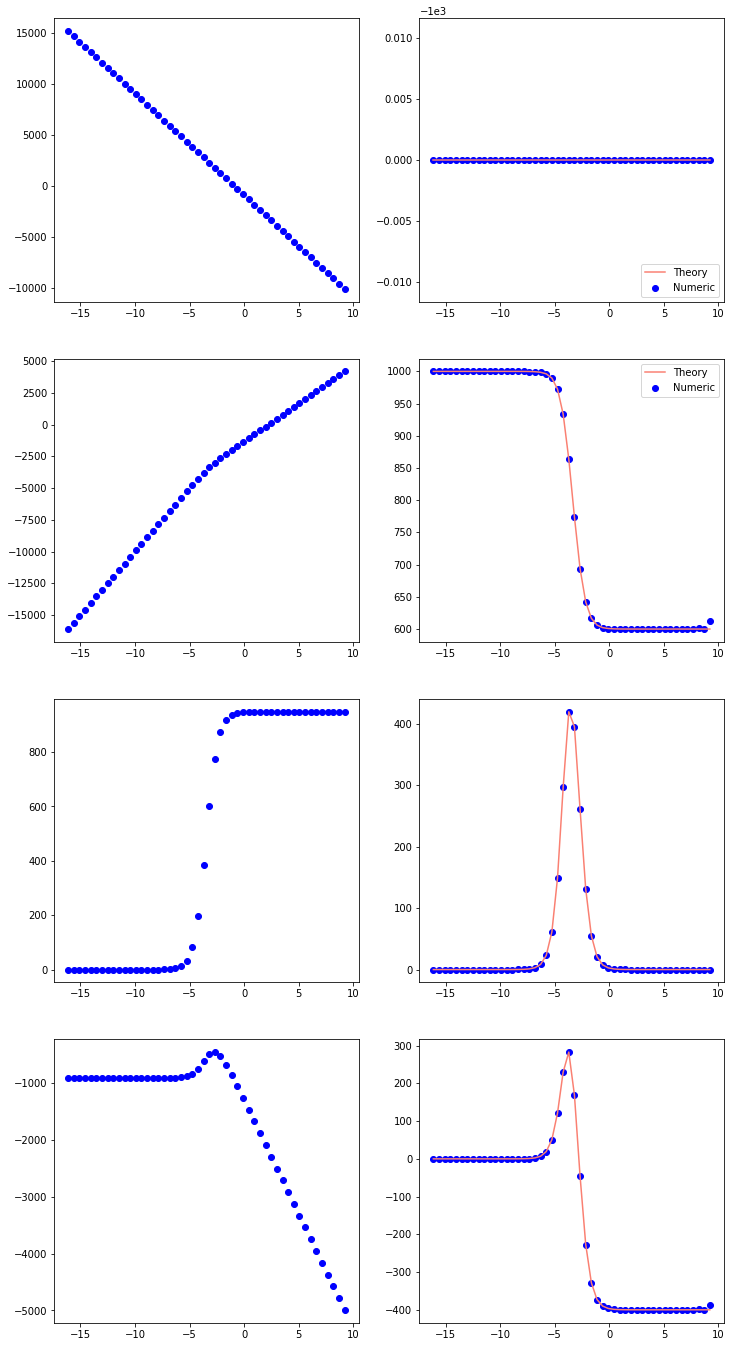

In [18]:
fig = plt.figure(figsize = (12, 24))
ax1 = fig.add_subplot(421)
ax2 = fig.add_subplot(422)
ax3 = fig.add_subplot(423)
ax4 = fig.add_subplot(424)
ax5 = fig.add_subplot(425)
ax6 = fig.add_subplot(426)
ax7 = fig.add_subplot(427)
ax8 = fig.add_subplot(428)


ax1.scatter(np.log(sigmabeta), y1, color = 'blue')
ax2.scatter(np.log(sigmabeta), y1_gradnumeric, color = 'blue', label = 'Numeric')
ax2.plot(np.log(sigmabeta), y1_gradtheory,  color = 'salmon', label = 'Theory')

ax3.scatter(np.log(sigmabeta), y2, color = 'blue')
ax4.scatter(np.log(sigmabeta), y2_gradnumeric, color = 'blue', label = 'Numeric')
ax4.plot(np.log(sigmabeta), y2_gradtheory,  color = 'salmon', label = 'Theory')

ax5.scatter(np.log(sigmabeta), y3, color = 'blue')
ax6.scatter(np.log(sigmabeta), y3_gradnumeric, color = 'blue', label = 'Numeric')
ax6.plot(np.log(sigmabeta), y3_gradtheory,  color = 'salmon', label = 'Theory')

y = [sum(x) for x in zip(y1, y2, y3)]
y_gradnumeric = [sum(x) for x in zip(y1_gradnumeric, y2_gradnumeric, y3_gradnumeric)]
y_gradtheory = [sum(x) for x in zip(y1_gradtheory, y2_gradtheory, y3_gradtheory)]
ax7.scatter(np.log(sigmabeta), y, color = 'blue')
ax8.scatter(np.log(sigmabeta), y_gradnumeric, color = 'blue', label = 'Numeric')
ax8.plot(np.log(sigmabeta), y_gradtheory,  color = 'salmon', label = 'Theory')

ax2.legend(loc = 'lower right')
ax4.legend(loc = 'upper right')
#ax1.set_ylim(-100000, 100000)
plt.show()